Setup Environment

In [1]:
!pip install transformers
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.8/105.8 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 KB 19.3 MB/s eta 0:00:0

In [4]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
device = torch.device("cuda")

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
%cd /content/drive/MyDrive/FakeNewsDetectionProject

/content/drive/MyDrive/FakeNewsDetectionProject


Load Dataset

In [12]:
true_data=pd.read_csv('True.csv')
fake_data=pd.read_csv('Fake.csv')

true_data['Target'] = ['True']*len(true_data)
fake_data['Target'] = ['Fake']*len(fake_data)

data = true_data.append(fake_data).sample(frac=1).reset_index().drop(columns=['index'])
print(data.shape)
data.head()

(44898, 5)


,title,text,subject,date,Target
0,The Reuters Graphic: North Korea's show of force,(Reuters) - North Korea’s latest display of it...,politicsNews,"April 27, 2017",True
1,Trump wants NATO to step up defense spending b...,BRUSSELS (Reuters) - U.S. President Donald Tru...,politicsNews,"February 20, 2017",True
2,Trump Threw Himself A Victory Party And Barel...,Trump s attempt at self-fellation following hi...,News,"December 2, 2016",Fake
3,"Despite EU caution, France pursues tough line ...",PARIS (Reuters) - France said on Wednesday it ...,worldnews,"November 15, 2017",True
4,Senator McCain wants Pentagon to probe United ...,WASHINGTON (Reuters) - U.S. Senate Armed Servi...,politicsNews,"March 17, 2016",True


In [13]:
data['label'] = pd.get_dummies(data.Target)['Fake']

In [14]:
data.head()

,title,text,subject,date,Target,label
0,The Reuters Graphic: North Korea's show of force,(Reuters) - North Korea’s latest display of it...,politicsNews,"April 27, 2017",True,0
1,Trump wants NATO to step up defense spending b...,BRUSSELS (Reuters) - U.S. President Donald Tru...,politicsNews,"February 20, 2017",True,0
2,Trump Threw Himself A Victory Party And Barel...,Trump s attempt at self-fellation following hi...,News,"December 2, 2016",Fake,1
3,"Despite EU caution, France pursues tough line ...",PARIS (Reuters) - France said on Wednesday it ...,worldnews,"November 15, 2017",True,0
4,Senator McCain wants Pentagon to probe United ...,WASHINGTON (Reuters) - U.S. Senate Armed Servi...,politicsNews,"March 17, 2016",True,0


([<matplotlib.patches.Wedge at 0x7f119c1af6d0>,
 [Text(-1.1968727067385088, -0.0865778485782335, 'Fake'),
  Text(1.1968726986325005, 0.08657796063754254, 'True')],
 [Text(-0.6981757455974634, -0.05050374500396954, '52.3%'),
  Text(0.6981757408689586, 0.05050381037189981, '47.7%')])

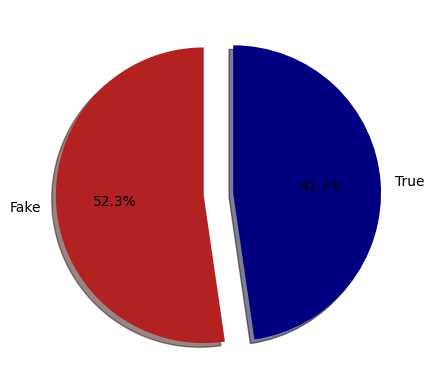

In [15]:
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

Train-Test Split

In [16]:
train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=data['Target'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

BERT Fine-Tuning

Load Pre-trained BERT Model

In [17]:
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Prepare Input Data

Text(0, 0.5, 'Number of texts')

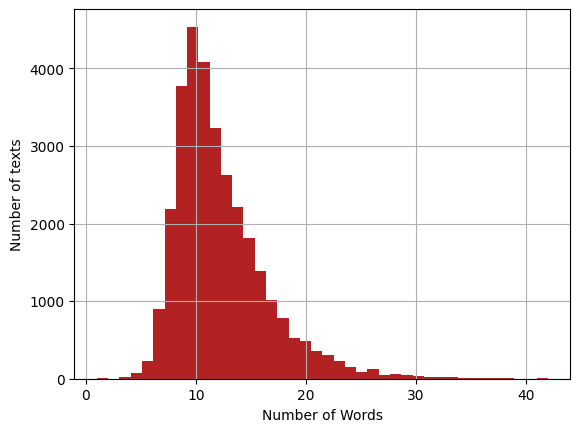

In [18]:
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [19]:
sample_data = ["Build fake news model.", 
               "Using bert."]                                        
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data,
                                                    padding=True)     
print(tokenized_sample_data)

{'input_ids': [[101, 3857, 8275, 2739, 2944, 1012, 102], [101, 2478, 14324, 1012, 102, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0]]}


In [21]:
MAX_LENGHT = 15

tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

In [22]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [23]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               

train_data = TensorDataset(train_seq, train_mask, train_y)   
train_sampler = RandomSampler(train_data)                     
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                             
val_data = TensorDataset(val_seq, val_mask, val_y)            
val_sampler = SequentialSampler(val_data)                     
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                             

In [24]:
for param in bert.parameters():
    param.requires_grad = False 

Define Model Architecture

In [27]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):  
      super(BERT_Arch, self).__init__()
      self.bert = bert   
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass  
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss() 
# Number of training epochs
epochs = 4

In [33]:
def train():  
  model.train()
  total_loss, total_accuracy = 0, 0
  
  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch 
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch  
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():  
   print("\nEvaluating...")  
   model.eval()                                    # Deactivate dropout layers
   total_loss, total_accuracy = 0, 0  
   for step,batch in enumerate(val_dataloader):    # Iterate over batches  
     if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.     
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
       print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
     batch = [t for t in batch]                    # Push the batch to GPU
     sent_id, mask, labels = batch
     with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
   avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
   return avg_loss

Model Training

In [34]:
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))     
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c2_new_model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 4
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  Batch   650  of    983.
  Batch   700  of    983.
  Batch   750  of    983.
  Batch   800  of    983.
  Batch   850  of    983.
  Batch   900  of    983.
  Batch   950  of    983.

Evaluating...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training Loss: 0.471
Validation Loss: 0.409

 Epoch 2 / 4
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  

Model Performance

In [36]:
path = 'c2_new_model_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [37]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      3212
           1       0.92      0.81      0.86      3523

    accuracy                           0.86      6735
   macro avg       0.87      0.87      0.86      6735
weighted avg       0.87      0.86      0.86      6735



Check for Fake News Predictions

In [38]:
# testing on unseen data
unseen_news_text = ["Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",     # Fake
                    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",               # Fake
                    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",           # True
                    "Trump administration issues new rules on U.S. visa waivers"                          # True
                    ]

# tokenize and encode sequences in the test set
MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds

array([1, 1, 0, 0])